# パイプラインによる効率化

In [2]:
import pandas as pd
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


32次元のデータ。
- 0：一意なID
- １：診断結果（M...悪性、B...良性）
- 3〜３1：デジタル画像から抽出された特徴量

In [6]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
# 元々B,Mの文字列で表示されているクラスを、0,1の表現に変換する
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [7]:
le.transform(['M', 'B'])

array([1, 0])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [14]:
# スケーリング（標準化）
sc =StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# 主成分分析
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# ロジスティック回帰
lr = LogisticRegression(random_state=1, solver='lbfgs')
lr.fit(X_train_pca, y_train)

# --------------------------
# テストデータ
y_pred = lr.predict(X_test_pca)

lr.score(X_test_pca, y_test)

0.956140350877193

以上の流れを、パイプラインを使うことで、各ステップで `fit`、`transform`..を書かなくても1行で済ますことができる。

In [13]:
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(random_state=1, solver='lbfgs'))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

pipe_lr.score(X_test, y_test)

0.956140350877193

# 層化k分割交差検証 (k-fold cross validation)

In [16]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold {}, Class dist.:{}, Acc{}'.format(k+1, np.bincount(y_train[train]), score))

Fold 1, Class dist.:[256 153], Acc0.9347826086956522
Fold 2, Class dist.:[256 153], Acc0.9347826086956522
Fold 3, Class dist.:[256 153], Acc0.9565217391304348
Fold 4, Class dist.:[256 153], Acc0.9565217391304348
Fold 5, Class dist.:[256 153], Acc0.9347826086956522
Fold 6, Class dist.:[257 153], Acc0.9555555555555556
Fold 7, Class dist.:[257 153], Acc0.9777777777777777
Fold 8, Class dist.:[257 153], Acc0.9333333333333333
Fold 9, Class dist.:[257 153], Acc0.9555555555555556
Fold 10, Class dist.:[257 153], Acc0.9555555555555556


# 学習曲線


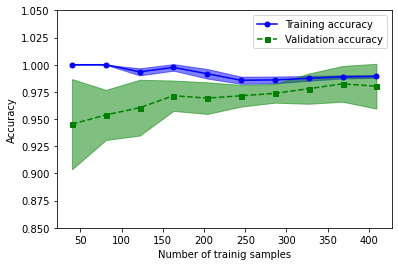

In [21]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(
    StandardScaler(), 
    LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', max_iter=10000)
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean-train_std, alpha=0.5, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean-test_std, alpha=0.5, color='green')

plt.xlabel('Number of trainig samples')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.ylim([0.85, 1.05])
plt.show()

# 検証曲線

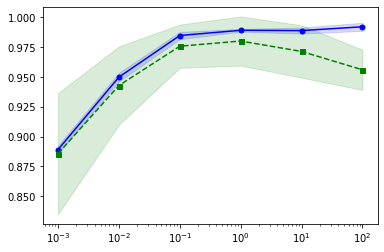

In [27]:
from sklearn.model_selection import validation_curve
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]

train_scores, test_scores = validation_curve(
    estimator=pipe_lr, 
    X=X_train,
    y=y_train,
    param_name = 'logisticregression__C',
    param_range=param_range, cv=10
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validatoin accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.xscale('log')

plt.show()

# グリッドサーチ

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'svc__C' : param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 refit=True,
                 n_jobs=-1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)

0.9846859903381642


In [29]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [32]:
from sklearn.model_selection import cross_val_score

gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=2
                 )

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('Accuracy {} +/- {}'.format(np.mean(scores), np.std(scores)))

Accuracy 0.9736263736263737 +/- 0.014906219743132467


# その他の性能評価指標

In [33]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

print(confmat)

[[71  1]
 [ 2 40]]


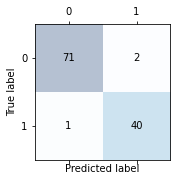

In [34]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()